In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from scipy.stats import bootstrap
import json
import mdtraj as md
import glob

In [2]:
sidechain_ensemble_dir = '../../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/sidechain_ensemble_withH'

In [3]:
plot_names_dict = {'af2chi':'AF2χ', 'af2chi_prior':'AF2χ prior', 'charmm36m':'CHARMM36m', 'ff99sb':'ff99SB', 'ff99sb_ildn':'ff99SB-ILDN', 'af2_structure':'AF2 structure', 'pdb_ensemble':'HSP ensemble'}

In [4]:
for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi=frame 
    else:
        ensemble_af2chi = ensemble_af2chi.join(frame)

In [5]:
sidechain_ensemble_dir_norew = '../../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/sidechain_ensemble_withH_norew'

In [6]:
for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi_prior=frame 
    else:
        ensemble_af2chi_prior = ensemble_af2chi_prior.join(frame)

In [7]:
dihedral_angles = np.arange(5, 360, 5) 

In [8]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

In [9]:
def karplus(karplus_coeffs, phi):
    A, B, C, delta = karplus_coeffs
    j3 = A*np.cos(phi+delta)*np.cos(phi+delta) + B*np.cos(phi+delta) + C
    return j3

In [10]:
#Val, Ile, Thr (C and N) from https://pubs.acs.org/doi/10.1021/ja029972s
#Rest from https://pubs.acs.org/doi/10.1021/ja003724j
karplus_coeffs_dict =  {'VAL_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'ILE_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'THR_C': [2.76, -0.67, 0.19, np.deg2rad(17)],
                        
                        'ASN_C': [2.31, -0.87, 1.37, 0],
                        'ASP_C': [2.31, -0.87, 1.06, 0],
                        'HIS_C': [2.31, -0.87, 0.98, 0],
                        'MET_C': [2.31, -0.87, 0.61, 0],
                        'ARG_C': [2.31, -0.87, 0.57, 0],
                        'GLU_C': [2.31, -0.87, 0.57, 0],
                        'GLN_C': [2.31, -0.87, 0.57, 0],
                        'LYS_C': [2.31, -0.87, 0.57, 0],
                        'PRO_C': [2.31, -0.87, 0.57, 0],
                        'LEU_C': [2.31, -0.87, 0.53, 0],
                        'PHE_C': [2.31, -0.87, 0.49, 0],
                        'TRP_C': [2.31, -0.87, 0.49, 0],
                        'TYR_C': [2.31, -0.87, 0.49, 0],
                        
                        'VAL_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'ILE_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'THR_N': [2.01, 0.21, -0.12, np.deg2rad(7)],
                        
                        'ASN_N': [1.29, -0.49, 0.89, 0],
                        'ASP_N': [1.29, -0.49, 0.70, 0],
                        'HIS_N': [1.29, -0.49, 0.65, 0],
                        'MET_N': [1.29, -0.49, 0.41, 0],
                        'ARG_N': [1.29, -0.49, 0.39, 0],
                        'GLN_N': [1.29, -0.49, 0.39, 0],
                        'GLU_N': [1.29, -0.49, 0.39, 0],
                        'LYS_N': [1.29, -0.49, 0.39, 0],
                        'LEU_N': [1.29, -0.49, 0.36, 0],
                        'PRO_N': [1.29, -0.49, 0.36, 0],
                        'PHE_N': [1.29, -0.49, 0.34, 0],
                        'TRP_N': [1.29, -0.49, 0.34, 0],
                        'TYR_N': [1.29, -0.49, 0.34, 0],
                        
                        'ALA_HAHB': [7.23, -1.37, 3.01, 0],
                        'ARG_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASN_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASP_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLN_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLU_HAHB': [7.23, -1.37, 2.40, 0],
                        'HIS_HAHB': [7.23, -1.37, 2.40, 0],
                        'LEU_HAHB': [7.23, -1.37, 2.40, 0],
                        'LYS_HAHB': [7.23, -1.37, 2.40, 0],
                        'MET_HAHB': [7.23, -1.37, 2.40, 0],
                        'PHE_HAHB': [7.23, -1.37, 2.40, 0],
                        'PRO_HAHB': [7.23, -1.37, 2.40, 0],
                        'TRP_HAHB': [7.23, -1.37, 2.40, 0],
                        'TYR_HAHB': [7.23, -1.37, 2.40, 0],
                        'ILE_HAHB': [7.23, -1.37, 1.79, 0],
                        'VAL_HAHB': [7.23, -1.37, 1.79, 0],
                        'CYS_HAHB': [7.23, -1.37, 1.71, 0],
                        'SER_HAHB': [7.23, -1.37, 1.42, 0],
                        'THR_HAHB': [7.23, -1.37, 0.81, 0],

                        'ALA_CHB': [4.02, -1.58, 1.71, 0],
                        'ARG_CHB': [4.02, -1.58, 1.41, 0],
                        'ASN_CHB': [4.02, -1.58, 1.41, 0],
                        'ASP_CHB': [4.02, -1.58, 1.41, 0],
                        'GLN_CHB': [4.02, -1.58, 1.41, 0],
                        'GLU_CHB': [4.02, -1.58, 1.41, 0],
                        'HIS_CHB': [4.02, -1.58, 1.41, 0],
                        'LEU_CHB': [4.02, -1.58, 1.41, 0],
                        'LYS_CHB': [4.02, -1.58, 1.41, 0],
                        'MET_CHB': [4.02, -1.58, 1.41, 0],
                        'PHE_CHB': [4.02, -1.58, 1.41, 0],
                        'PRO_CHB': [4.02, -1.58, 1.41, 0],
                        'TRP_CHB': [4.02, -1.58, 1.41, 0],
                        'TYR_CHB': [4.02, -1.58, 1.41, 0],
                        'ILE_CHB': [4.02, -1.58, 1.10, 0],
                        'VAL_CHB': [4.02, -1.58, 1.10, 0],
                        'CYS_CHB': [4.02, -1.58, 1.06, 0],
                        'SER_CHB': [4.02, -1.58, 0.91, 0],
                        'THR_CHB': [4.02, -1.58, 0.61, 0],
                                  }

In [11]:
def calc_C_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    print(list(res_slice.topology.atoms))

    index_1 = res_slice.top.select('name C')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    print(split_atom_names)

    if 'HB' == split_atom_names[-1]: 
            index_4 = res_slice.top.select('name HB')[0]
    else:
        try: 
            res_slice.top.select('name HB3')[0]
            print('There is an HB3, so assuming HB2 HB3 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB3')[0]
            else:
                raise Exception('No correct HB found')
        except:
            print('There is no HB3, so assuming HB1 HB2 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB1')[0]
            else:
                raise Exception('No correct HB found')
    

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    print(atom_idxs)
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))

    #print(angles)

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)

    print(j3_calc_avg)

    return j3_calc_avg


In [12]:
def calc_HA_CA_CB_HB_jcoupling_OLD(res_slice, atoms_line, karplus_coeffs):
    
    print(list(res_slice.topology.atoms))

    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    print(split_atom_names)

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]

    elif '1HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB2')[0]

    elif '2HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB3')[0]
    else:
        raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    print(atom_idxs)
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))

    #print(angles)

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)

    print(j3_calc_avg)

    return j3_calc_avg


In [13]:
def calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]
    else:
        try: 
            res_slice.top.select('name HB3')[0]
            print('There is an HB3, so assuming HB2 HB3 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB3')[0]
            else:
                raise Exception('No correct HB found')
        except:
            print('There is no HB3, so assuming HB1 HB2 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB1')[0]
            else:
                raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [14]:
def get_atoms_lines(exp_j3_df, resnum):
    #Get rows of experimental data with resid
    row = exp_j3_df[exp_j3_df['resid'] == resnum]
    
    #Get the label with atoms (there can be multiple lines for one resid if there are multiple CG)
    atoms_lines = row['label'].values

    return atoms_lines

In [15]:
ensembles = {}

ensembles['af2chi'] = ensemble_af2chi
ensembles['af2chi_prior'] = ensemble_af2chi_prior
af2_structure = md.load('../../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/af2_struc.pdb')
ensembles['af2_structure'] = af2_structure
charmm36m_traj = md.load('../../data/MD_data/MD_charmm36m/HEWL.xtc', top='../../data/MD_data/MD_charmm36m/HEWL.gro')
ensembles['charmm36m'] = charmm36m_traj


In [16]:
exp_j3_C_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/HEWL_expt/HEWL_C_CA_CB_HB.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/HEWL_expt/HEWL_HA_CA_CB_HB.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])


/tmp/ipykernel_209412/4268479211.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_C_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/HEWL_expt/HEWL_C_CA_CB_HB.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_209412/4268479211.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/HEWL_expt/HEWL_HA_CA_CB_HB.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])


In [17]:
pdb_ensemble_dir='../../data/hsp_ensembles/HEWL_withH'
pdbs_pdbens = glob.glob(f'{pdb_ensemble_dir}/*.pdb')

In [18]:
j3_results = {}
#j3_results_reversedassignment = {}

for ensemble_type in ensembles.keys():
    
    traj = ensembles[ensemble_type]
    
    j3_vs_dihedraltype = {}
    if ensemble_type == 'af2_structure':
        j3_vs_dihedraltype_pdbens = {}
    #j3_vs_dihedraltype_reversedassignment = {}

    for residue in ensembles[ensemble_type].top.residues:
        residue = str(residue)
        #restype=residue[:3]
        #resnum=i+1 #int(residue[3:])

        resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
        restype = str(''.join(filter(lambda x: x.isalpha(), residue)))

        print(resnum, restype)
  
        C_karplus_params_available = True
        H_karplus_params_available = True
        
        resatoms = traj.top.select(f'resi {resnum-1} and resname {restype}')

        if 'HIS' in restype:
            restype = 'HIS'

        res_slice = traj.atom_slice(resatoms)

        #Get Karplus parameters
        try:
            karplus_coeffs_HA_CA_CB_HB = karplus_coeffs_dict[f'{restype}_HAHB']
        except:
            print(f'No HAHB Karplus params for {restype}')
            H_karplus_params_available = False
        
        if H_karplus_params_available == True:
            atoms_lines_HA_CA_CB_HB = get_atoms_lines(exp_j3_HA_CA_CB_HB, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_HA_CA_CB_HB:
                print(atoms_line)
                j3_HA_CA_CB_HB= calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                #j3_HA_CA_CB_HB_reversedassignment = calc_HA_CA_CB_HB_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB_reversedassignment

                if ensemble_type == 'af2_structure':
                    j3_vs_pdb_ens_frame = []
                    for pdb in pdbs_pdbens:
                        pdb_traj = md.load(pdb)
                        pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname {restype}')

                        #For Histidine try differennt types until you get the atom selection
                        if restype == 'HIS' and len(pdb_resatoms) == 0:
                            pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname HISH')

                        if len(pdb_resatoms) > 0:
                            pdb_res_slice = pdb_traj.atom_slice(pdb_resatoms)
                            j3_pdb = calc_HA_CA_CB_HB_jcoupling(pdb_res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                            j3_vs_pdb_ens_frame.append(j3_pdb)
                        else:
                            print(f'No atoms for {resnum}{restype} in {pdb}')
                    if len(j3_vs_pdb_ens_frame) >= 10:
                        j3_pdb_ens_frame_avg = np.average(j3_vs_pdb_ens_frame)
                        j3_vs_dihedraltype_pdbens[f'{resnum}_{atoms_line}'] = j3_pdb_ens_frame_avg
                    else:
                        print(f'Not enough frames for {resnum}{restype} in pdb ensemble')

        #Get Karplus parameters
        try:
            karplus_coeffs_C_CA_CB_HB = karplus_coeffs_dict[f'{restype}_CHB']
        except:
            print(f'No C Karplus params for {restype}')
            C_karplus_params_available = False
            
        if C_karplus_params_available == True:
            
            atoms_lines_C_CA_CB_HB = get_atoms_lines(exp_j3_C_CA_CB_HB, resnum)
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_C_CA_CB_HB:
                j3_C_CA_CB_HB = calc_C_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs_C_CA_CB_HB)
                #j3_C_CA_CB_HB_reversedassignment = calc_C_CA_CB_HB_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_C_CA_CB_HB)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_HB
                #j3_vs_dihedraltype_reversedassignment [atoms_line] = j3_C_CA_CB_HB_reversedassignment 

                if ensemble_type == 'af2_structure':
                    j3_vs_pdb_ens_frame = []
                    for pdb in pdbs_pdbens:
                        pdb_traj = md.load(pdb)
                        pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname {restype}')

                        #For Histidine try differennt types until you get the atom selection
                        if restype == 'HIS' and len(pdb_resatoms) == 0:
                            pdb_resatoms = pdb_traj.top.select(f'resi {resnum-1} and resname HISH')

                        if len(pdb_resatoms) > 0:
                            pdb_res_slice = pdb_traj.atom_slice(pdb_resatoms)
                            j3_pdb = calc_C_CA_CB_HB_jcoupling(pdb_res_slice, atoms_line, karplus_coeffs_C_CA_CB_HB)
                            j3_vs_pdb_ens_frame.append(j3_pdb)
                        else:
                            print(f'No atoms for {resnum}{restype} in {pdb}')
                    if len(j3_vs_pdb_ens_frame) >= 10:
                        j3_pdb_ens_frame_avg = np.average(j3_vs_pdb_ens_frame)
                        j3_vs_dihedraltype_pdbens[f'{resnum}_{atoms_line}'] = j3_pdb_ens_frame_avg
                    else:
                        print(f'Not enough frames for {resnum}{restype} in pdb ensemble')

    j3_results[ensemble_type] = j3_vs_dihedraltype
    if ensemble_type == 'af2_structure':
        j3_results['pdb_ensemble'] = j3_vs_dihedraltype_pdbens
    #j3_results_reversedassignment[ensemble_type] = j3_vs_dihedraltype_reversedassignment

1 LYS
2 VAL
2_HA_2_CA_2_CB_2_HB
[VAL2-N, VAL2-H, VAL2-CA, VAL2-HA, VAL2-CB, VAL2-HB, VAL2-CG1, VAL2-HG11, VAL2-HG12, VAL2-HG13, VAL2-CG2, VAL2-HG21, VAL2-HG22, VAL2-HG23, VAL2-C, VAL2-O]
['C', 'CA', 'CB', 'HB']
[14  2  4  5]
1.3163803
3 PHE
3_HA_3_CA_3_CB_3_1HB
There is an HB3, so assuming HB2 HB3 naming
3_HA_3_CA_3_CB_3_2HB
There is an HB3, so assuming HB2 HB3 naming
[PHE3-N, PHE3-H, PHE3-CA, PHE3-HA, PHE3-CB, PHE3-HB3, PHE3-HB2, PHE3-CG, PHE3-CD1, PHE3-HD1, PHE3-CE1, PHE3-HE1, PHE3-CZ, PHE3-HZ, PHE3-CE2, PHE3-HE2, PHE3-CD2, PHE3-HD2, PHE3-C, PHE3-O]
['C', 'CA', 'CB', '1HB']
There is an HB3, so assuming HB2 HB3 naming
[18  2  4  6]
1.4495435
[PHE3-N, PHE3-H, PHE3-CA, PHE3-HA, PHE3-CB, PHE3-HB3, PHE3-HB2, PHE3-CG, PHE3-CD1, PHE3-HD1, PHE3-CE1, PHE3-HE1, PHE3-CZ, PHE3-HZ, PHE3-CE2, PHE3-HE2, PHE3-CD2, PHE3-HD2, PHE3-C, PHE3-O]
['C', 'CA', 'CB', '2HB']
There is an HB3, so assuming HB2 HB3 naming
[18  2  4  5]
2.6859052
4 GLY
No HAHB Karplus params for GLY
No C Karplus params for GLY
5 AR

In [19]:
def make_plot_arrays_dict(j3_results_dict, exp_j3_df):

    j3_results_arrs = {}
    for ensemble_type in j3_results_dict.keys():
        ensemble_j3s = j3_results_dict[ensemble_type]

        ensemble_j3_arr = []
        for resnum, atoms_line in zip(exp_j3_df['resid'], exp_j3_df['label']):
            print(ensemble_type)
            print(resnum, atoms_line)
            ensemble_j3_arr.append(ensemble_j3s[f'{resnum}_{atoms_line}'])
        j3_results_arrs[ensemble_type] = np.array(ensemble_j3_arr)

    return j3_results_arrs


In [20]:
j3_results_arrs_C_CA_CB_HB = make_plot_arrays_dict(j3_results, exp_j3_C_CA_CB_HB)
j3_results_arrs_C_CA_CB_HB['ff99sb'] = np.array(exp_j3_C_CA_CB_HB['ff99sb'])
j3_results_arrs_C_CA_CB_HB['ff99sb_ildn'] = np.array(exp_j3_C_CA_CB_HB['ff99sb_ildn'])

j3_results_arrs_HA_CA_CB_HB = make_plot_arrays_dict(j3_results, exp_j3_HA_CA_CB_HB)
j3_results_arrs_HA_CA_CB_HB['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
j3_results_arrs_HA_CA_CB_HB['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

#j3_results_arrs_C_CA_CB_HB_reversedassignment = make_plot_arrays_dict(j3_results_reversedassignment, exp_j3_C_CA_CB_HB)
#j3_results_arrs_C_CA_CB_HB_reversedassignment['ff99sb'] = np.array(exp_j3_C_CA_CB_HB['ff99sb'])
#j3_results_arrs_C_CA_CB_HB_reversedassignment['ff99sb_ildn'] = np.array(exp_j3_C_CA_CB_HB['ff99sb_ildn'])

#j3_results_arrs_HA_CA_CB_HB_reversedassignment = make_plot_arrays_dict(j3_results_reversedassignment, exp_j3_HA_CA_CB_HB)
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

af2chi
2 2_C_2_CA_2_CB_2_HB
af2chi
3 3_C_3_CA_3_CB_3_1HB
af2chi
3 3_C_3_CA_3_CB_3_2HB
af2chi
6 6_C_6_CA_6_CB_6_1HB
af2chi
6 6_C_6_CA_6_CB_6_2HB
af2chi
8 8_C_8_CA_8_CB_8_1HB
af2chi
8 8_C_8_CA_8_CB_8_2HB
af2chi
12 12_C_12_CA_12_CB_12_1HB
af2chi
12 12_C_12_CA_12_CB_12_2HB
af2chi
15 15_C_15_CA_15_CB_15_1HB
af2chi
17 17_C_17_CA_17_CB_17_1HB
af2chi
17 17_C_17_CA_17_CB_17_2HB
af2chi
18 18_C_18_CA_18_CB_18_1HB
af2chi
20 20_C_20_CA_20_CB_20_1HB
af2chi
20 20_C_20_CA_20_CB_20_2HB
af2chi
23 23_C_23_CA_23_CB_23_1HB
af2chi
23 23_C_23_CA_23_CB_23_2HB
af2chi
24 24_C_24_CA_24_CB_24_1HB
af2chi
24 24_C_24_CA_24_CB_24_2HB
af2chi
27 27_C_27_CA_27_CB_27_1HB
af2chi
27 27_C_27_CA_27_CB_27_2HB
af2chi
30 30_C_30_CA_30_CB_30_1HB
af2chi
30 30_C_30_CA_30_CB_30_2HB
af2chi
33 33_C_33_CA_33_CB_33_1HB
af2chi
33 33_C_33_CA_33_CB_33_2HB
af2chi
34 34_C_34_CA_34_CB_34_1HB
af2chi
34 34_C_34_CA_34_CB_34_2HB
af2chi
38 38_C_38_CA_38_CB_38_1HB
af2chi
38 38_C_38_CA_38_CB_38_2HB
af2chi
39 39_C_39_CA_39_CB_39_1HB
af2chi
39 39_C_3

In [21]:
def make_plot(j3_exp_arr_C, j3_exp_arr_HAHB, j3_ensemble_arr_C, j3_ensemble_arr_HAHB, title, outfile):

    pltmax = np.amax([ *j3_exp_arr_C, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_HAHB])
    pltmax += 0.1*pltmax
    pltmin = np.amin([*j3_exp_arr_C, *j3_exp_arr_HAHB,  *j3_ensemble_arr_C, *j3_ensemble_arr_HAHB])
    pltmin -= 0.1*pltmax
    
    RMSE_C = root_mean_squared_error(j3_exp_arr_C, j3_ensemble_arr_C)
    RMSE_HAHB = root_mean_squared_error(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB)
    
    #Plotting
    fig = plt.figure(figsize=(4,4))

    plt.title(title, fontsize=15)
    
    plt.plot([-100,100], [-100,100], '--', color='black')

    plt.plot(j3_exp_arr_C, j3_ensemble_arr_C, 'o', c='black', markeredgecolor='black', label='C\'-Cα-Cβ-Hβ') #(RMSE={RMSE_C:.2})')
    plt.plot(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB, 'o', c='gray', markeredgecolor='black', label='Hα-Cα-Cβ-Hβ') #(RMSE={RMSE_HAHB:.2})')
    
    plt.xlabel('$^3J$ experiment (Hz)', fontsize=15)
    plt.ylabel('$^3J$ model (Hz)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xlim(pltmin, pltmax)
    plt.ylim(pltmin, pltmax)
    
    plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)
    
    plt.savefig(outfile, bbox_inches='tight')

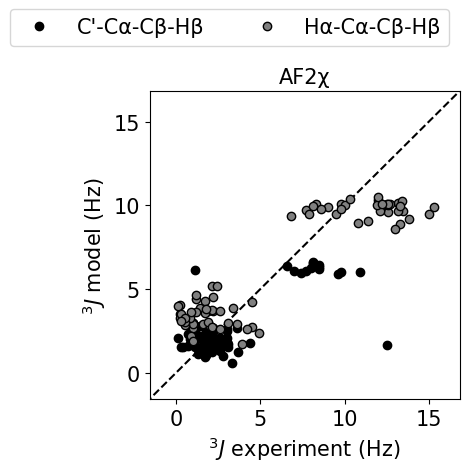

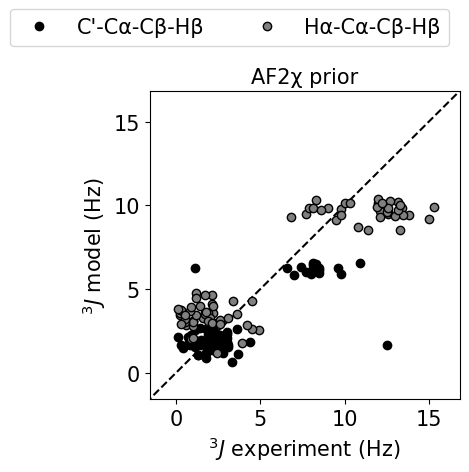

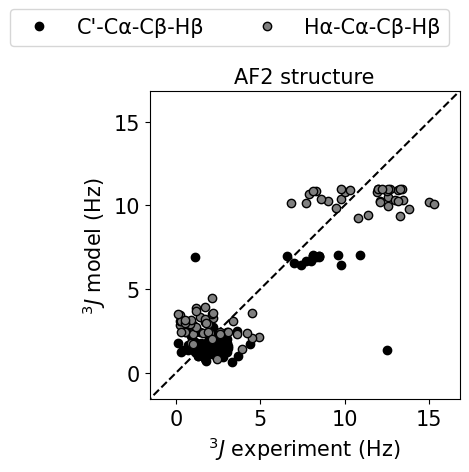

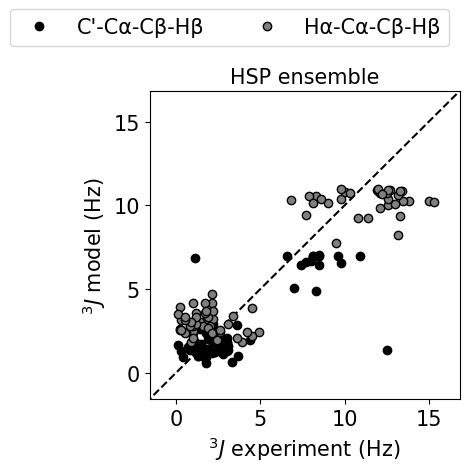

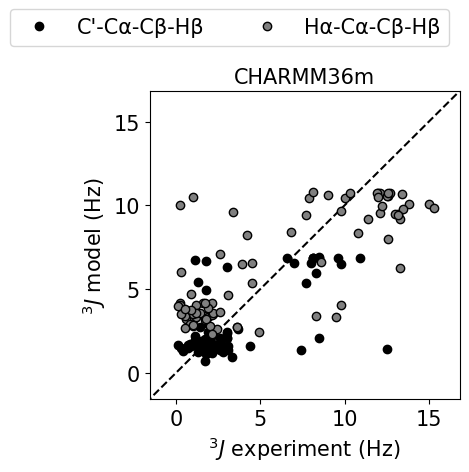

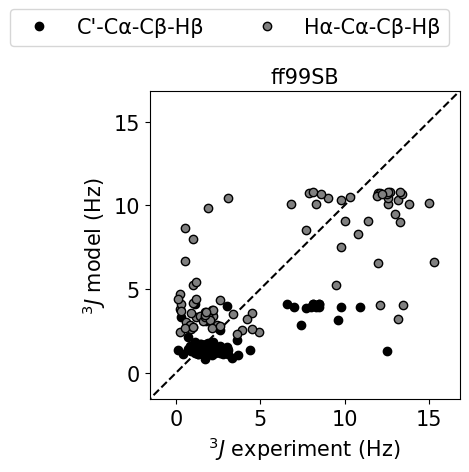

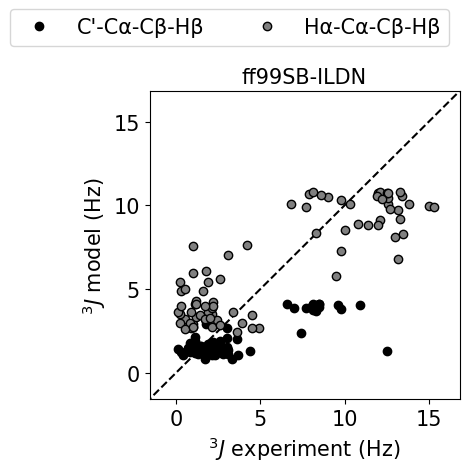

In [22]:
for ensemble_type in j3_results_arrs_C_CA_CB_HB.keys():
    make_plot(np.array(exp_j3_C_CA_CB_HB['exp']), np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_HB[ensemble_type], j3_results_arrs_HA_CA_CB_HB[ensemble_type], plot_names_dict[ensemble_type], f'../../figures/hewl_{ensemble_type}_jcouplings.pdf')

# Plot RMSEs split by dihedral type

af2chi 2.0214793439095637 0.40577518712440325
af2chi_prior 2.009427262147152 0.40093065464287675
af2_structure 1.9508033071982633 0.44688168154804997
pdb_ensemble 1.9940126016274602 0.4366018661256023
charmm36m 2.377070337296815 0.39451298655334416
ff99sb 2.7147014875795583 0.3661564070665325
ff99sb_ildn 2.685044485458088 0.36342874272254116


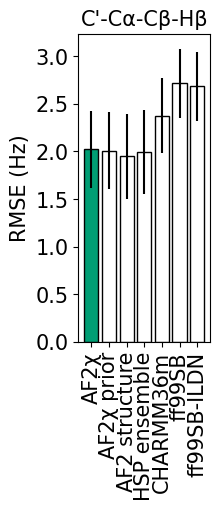

In [23]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_C_CA_CB_HB.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_C_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_HB[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_C_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_HB[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_C_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_HB[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.7,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('C\'-Cα-Cβ-Hβ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/hewl_RMSEjcouplings_C_CA_CB_HB_bar.pdf', bbox_inches='tight')

af2chi 2.477459620618179 0.13492669668887958
af2chi_prior 2.507878587812172 0.13745753474207403
af2_structure 2.138929691650642 0.12314074081464121
pdb_ensemble 2.199541404717236 0.12759989390683235
charmm36m 3.3151213811162346 0.2758741302481071
ff99sb 3.591246043944657 0.32202323841036506
ff99sb_ildn 2.926259357466541 0.16792349537312964


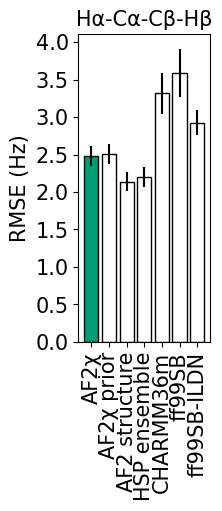

In [24]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_HA_CA_CB_HB.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.7,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('Hα-Cα-Cβ-Hβ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/hewl_RMSEjcouplings_HA_CA_CB_HB_bar.pdf', bbox_inches='tight')